In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# Generate random real nxn block hermitian matrix with block size b
def randHerm(n, d):
    A = np.random.rand(n, d*n)
    return (A@A.T)/n

In [3]:
def randVec(n, b = 1):
    return np.random.rand(n, b)

In [4]:
def block_lanczos(H,V,k,reorth = 0):
    """
    Input
    -----
    
    H    : d x d matrix
    V    : d x b starting block
    k    : number of iterations
    
    Returns
    -------
    Q1k  : First k blocks of Lanczos vectors
    Qkp1 : final block of Lanczos vetors
    A    : diagonal blocks
    B    : off diagonal blocks (incuding block for starting with non-orthogonal block)
    """

    Z = np.copy(V)
    d,b = Z.shape
    
    A = [np.zeros((b,b),dtype=H.dtype)] * k
    B = [np.zeros((b,b),dtype=H.dtype)] * (k+1)
    
    Q = np.zeros((d,b*(k+1)),dtype=H.dtype)

    # B[0] accounts for non-orthogonal V and is not part of tridiagonal matrix
    Q[:,0:b],B[0] = np.linalg.qr(Z)
    for j in range(0,k):
        
#       Qj is the next column of blocks
        Qj = Q[:,j*b:(j+1)*b]

        if j == 0:
            Z = H@Qj
        else:
            Qjm1 = Q[:,(j-1)*b:j*b]
            Z = H @ Qj - Qjm1 @ (B[j].conj().T)
     
        A[j] = Qj.conj().T @ Z
        Z -= Qj @ A[j]
        
        # double reorthogonalization if needed
        if reorth > j:
            Z -= Q[:,:j * b] @ (Q[:,:j * b].conj().T @ Z)
            Z -= Q[:,:j * b] @ (Q[:,:j * b].conj().T @ Z)
        
        Q[:,(j+1)*b:(j+2)*b],B[j + 1] = np.linalg.qr(Z)
    
    Q1k = Q[:,:b*k]
    Qkp1 = Q[:,b*k:]

    return Q1k, Qkp1, A, B

In [5]:
def get_block_tridiag(A,B):
    """
    Input
    -----
    
    A  : diagonal blocks
    B  : off diagonal blocks
    
    Returns
    -------
    T  : block tridiagonal matrix
    
    """
    
    q = len(A)
    b = len(A[0])
    
    T = np.zeros((q*b,q*b),dtype=A[0].dtype)

    for k in range(q):
        T[k*b:(k+1)*b,k*b:(k+1)*b] = A[k]

    for k in range(q-1):
        T[(k+1)*b:(k+2)*b,k*b:(k+1)*b] = B[k]
        T[k*b:(k+1)*b,(k+1)*b:(k+2)*b] = B[k].conj().T
    
    return T

In [6]:
# k is number of blocks, b block size, i is the position of the identity matrix
def Ei(n, b, i):
    """
    Input
    -----
    
    n  : matrix size
    b  : block size
    i  : position of diagonal block (the first block is when i = 1)
    
    Returns
    -------
    Ei  : block zero vector with identity in i-th position
    
    """
    if (i == 0 or i > n/b):
        raise ValueError("Illegal Index")
    Ei = np.zeros((n,b))
    Ei[(i-1)*b:i*b,:] = np.identity(b)
    
    return Ei

In [7]:
def poly_func(order, coeff, x):
    """
    Input
    -----
    
    order  : order of the polynomial
    coeff  : coefficient of the terms in increasing power
    x  : the points x to evaluate at
    
    Returns
    -------
    y  : the polynomial evaluated at x
    
    """
    
#     Note: Will randomize coefficient if the number of coefficients given does not match order of polynomial perfectly.
    if (len(coeff) != order+1 or coeff == None):
        coeff = np.random.rand(order+1)
        
    y = np.zeros(len(x)) + coeff[0]
    for i in np.arange(order):
        y += coeff[i+1]*x**(i+1)
        
    return y

In [8]:
def exp(x):
    """
    Input
    -----

    x  : the points x to evaluate at
    
    Returns
    -------
    y  : the exponential function evaluated at x
    
    """    
    return np.exp(x)

In [9]:
def x_inv(x):
    """
    Input
    -----

    x  : the points x to evaluate at
    
    Returns
    -------
    y  : the exponential function evaluated at x
    
    """    
    return 1/x

In [10]:
def check_Lanczos(Qk, T, Qkp1, B, H, k, thresh):
    """
    Input
    -----
    
    Qk, T, Qkp1, B, H  : Output of Block Lanczos Algorithm
    
    Returns
    -------
    raise value error if any of the two tests does not pass
    
    """
    t1val = np.linalg.norm(Qk.conj().T@Qk-np.identity(np.shape(Qk.T@Qk)[0]))
    t2val = np.linalg.norm(Qk@T + Qkp1@B[k]@Ei(k*b, b, k).conj().T - H@Qk)
    if (t1val > thresh):
        raise ValueError("Qk*Qk = I test failed, error = ", t1val)

    if (t2val > thresh):
        raise ValueError("Three term recurrence test failed, error = ", t2val)

In [11]:
def makeApproximation(Q, T, f, B, b, k, C = -1):
    """
    Input
    -----
            
    Qk, T  : Output of Block Lanczos Algorithm
    
    f  : Desired function.
    
    C  : aditional arguments for function f i.e. coefficients of poly_func.
        Poly: C[0] should be order, C[1] should be array of coefficients.
    
    Returns
    -------
    return the predicted result
    
    """
    if (f == poly_func):
        if (len(C[1]) != C[0] + 1):
            raise ValueError("Order of Polynomial does not match the dimension of given coefficients.")
    
    Eval, Evec = np.linalg.eigh(T)
    
    if (f == poly_func):
        fEval = f(C[0], C[1], Eval)
    else:
        fEval = f(Eval)

    return Q@(Evec@(np.diag(fEval)@(Evec.conj().T@Ei(k*b, b, 1))))@B[0]

In [12]:
# Hermitian matrix function
def HMF(H, f, C = -1):
    """
    Input
    -----
            
    H  : Hermitian matrix to be evaluated
    
    f  : Desired function.
    
    C  : aditional arguments for function f i.e. coefficients of poly_func.
        Poly: C[0] should be order, C[1] should be array of coefficients.
    
    Returns
    -------
    return f(H)
    
    """
    if (f == poly_func):
        if (len(C[1]) != C[0] + 1):
            raise ValueError("Order of Polynomial does not match the dimension of given coefficients.")
    
    Eval, Evec = np.linalg.eigh(H)
    
    if (f == poly_func):
        fEval = f(C[0], C[1], Eval)
    else:
        fEval = f(Eval)

    return Evec@np.diag(fEval)@Evec.conj().T

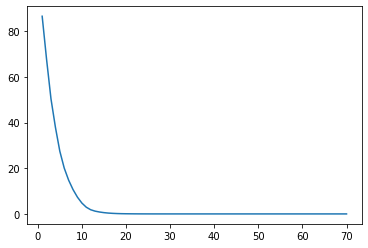

In [16]:
# Main script
# iter <= n/b
k = 100
b = 2
n = k*b
itr = 70

H = randHerm(n, b)
V = randVec(n, b)
    
Q, Qkp1, M, B = block_lanczos(H, V, itr, itr+1)
T = get_block_tridiag(M,B[1:])

check_Lanczos(Q, T, Qkp1, B, H, itr, 1)

real = HMF(H, x_inv)@V

error = np.zeros(itr)
x = np.arange(itr)+1
for j in x:
    approx = makeApproximation(Q[:,:j*b], T[0:j*b, 0:j*b], x_inv, B, b, j)
    error[j-1] = np.linalg.norm(approx-real)
    
plt.plot(x, error)